# Fase 4: Entrenamiento y Selección de Modelos de Clasificación

## Objetivo del Notebook

Este notebook constituye la cuarta fase del pipeline de mantenimiento predictivo para sistemas de moto-compresores. El objetivo principal es entrenar, evaluar y seleccionar un modelo de clasificación binaria capaz de predecir si ocurrirá una falla en los próximos 7 días, utilizando las características derivadas del proceso de ingeniería de características implementado en la fase anterior.

### Metodología de Entrenamiento

La metodología implementada se basa en principios fundamentales de machine learning para series temporales, priorizando:

1. **División Cronológica de Datos**: Implementación de una división temporal que respete la naturaleza secuencial de los datos operacionales, evitando la fuga de información (data leakage) que comprometería la validez del modelo.

2. **Manejo de Desbalance de Clases**: Aplicación de técnicas específicas para abordar la distribución desigual entre muestras de operación normal y muestras pre-falla, fundamental en aplicaciones de mantenimiento predictivo.

3. **Evaluación Robusta**: Utilización de métricas de rendimiento apropiadas para clasificación desbalanceada, que proporcionen una evaluación objetiva de la capacidad predictiva del modelo.

4. **Simplicidad Computacional**: Selección de algoritmos que mantengan un balance óptimo entre rendimiento predictivo y eficiencia computacional.

### Variable Objetivo Creada

La variable objetivo 'falla' ha sido creada basándose en el historial real de eventos de falla del compresor, donde:
- **Clase 0 (Normal)**: Operación normal del equipo
- **Clase 1 (Pre-falla)**: Muestras dentro de la ventana de 7 días previa a una falla documentada

### Librerías y Dependencias

El desarrollo requiere las siguientes librerías especializadas:
- **pandas, numpy**: Manipulación y procesamiento de datos
- **pathlib**: Gestión de rutas del sistema de archivos
- **joblib**: Serialización eficiente de modelos
- **matplotlib, seaborn**: Visualización de resultados y métricas
- **sklearn**: Algoritmos de machine learning, pipelines y métricas de evaluación

In [10]:
# Importación de librerías fundamentales para manipulación de datos
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización de resultados
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Importación de algoritmos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Importación de herramientas de pipeline y preprocesamiento
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # ✅ AGREGADO: Para manejo de valores NaN
from sklearn.model_selection import train_test_split

# Importación de métricas de evaluación para clasificación
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score
)

# Definición de rutas del proyecto
data_processed_path = Path('./data/processed')
models_path = Path('./data/models')

# Creación de directorio de modelos si no existe
models_path.mkdir(exist_ok=True)

print("Configuración del entorno completada exitosamente")
print(f"Directorio de datos procesados: {data_processed_path}")
print(f"Directorio de modelos: {models_path}")
print("✅ SimpleImputer agregado para manejo de valores NaN")

Configuración del entorno completada exitosamente
Directorio de datos procesados: data/processed
Directorio de modelos: data/models
✅ SimpleImputer agregado para manejo de valores NaN


## Paso 2: Carga y Preparación de Datos

### Proceso de Carga de Dataset

En esta etapa se procede a cargar el dataset resultante del proceso de ingeniería de características desarrollado en la fase anterior, ahora enriquecido con la variable objetivo 'falla' creada a partir del historial real de eventos de mantenimiento. El archivo se buscará primero como `featured_dataset_for_modeling.parquet` y si no se encuentra con variable objetivo, se buscará `featured_dataset_with_target.parquet`.

El dataset contiene:

- **Características originales de sensores**: Variables operacionales directas del moto-compresor
- **Características de ventanas móviles**: Estadísticos calculados sobre períodos temporales específicos
- **Características de lag temporal**: Variables retardadas que capturan dependencias temporales
- **Variable objetivo**: Indicador binario de proximidad a falla basado en eventos reales documentados

### Creación Automática de Variable Objetivo

Si la variable objetivo no existe, se ejecutará automáticamente el proceso de creación utilizando el historial de eventos de falla documentados. El proceso implementa:

1. **Extracción de Fechas**: Procesamiento automático de todas las fechas de eventos del historial
2. **Ventana de Pre-falla**: Definición de una ventana de 7 días previos a cada evento como período crítico
3. **Etiquetado**: Las muestras dentro de estas ventanas se etiquetan como 'pre-falla' (1), el resto como 'normal' (0)

### Separación de Características y Variable Objetivo

La preparación de datos requiere la separación clara entre la matriz de características (X) y el vector de variable objetivo (y) para el entrenamiento supervisado del modelo de clasificación.

In [11]:
# Carga del dataset con características de ingeniería y variable objetivo

# Intentar cargar primero el dataset con variable objetivo
dataset_with_target_path = data_processed_path / 'featured_dataset_with_target.parquet'
dataset_original_path = data_processed_path / 'featured_dataset_for_modeling.parquet'

if dataset_with_target_path.exists():
    dataset_path = dataset_with_target_path
    print(f"Cargando dataset con variable objetivo desde: {dataset_path}")
else:
    dataset_path = dataset_original_path
    print(f"Cargando dataset original desde: {dataset_path}")

try:
    df = pd.read_parquet(dataset_path)
    print(f"Dataset cargado exitosamente")
    print(f"Dimensiones del dataset: {df.shape}")
    print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Verificar si existe la variable objetivo
    if 'falla' not in df.columns:
        print("\n⚠️ Variable objetivo 'falla' no encontrada")
        print("Ejecutando creación automática de variable objetivo...")
        
        # Ejecutar script para crear variable objetivo
        import subprocess
        result = subprocess.run(['python', 'crear_variable_objetivo.py'], 
                              capture_output=True, text=True, cwd='.')
        print(result.stdout)
        if result.stderr:
            print(f"Errores: {result.stderr}")
        
        # Cargar el dataset actualizado
        df = pd.read_parquet(data_processed_path / 'featured_dataset_with_target.parquet')
        print(f"\n✅ Dataset actualizado cargado: {df.shape}")
        
except FileNotFoundError:
    print(f"Error: No se encontró el archivo {dataset_path}")
    print("Asegúrese de haber ejecutado el notebook 03_feature_engineering.ipynb")
    raise

# Verificación de la estructura del dataset
print("\n=== Información General del Dataset ===")
print(f"Columnas: {len(df.columns)}")
print(f"Filas: {len(df)}")

# Análisis de la variable objetivo
print("\n=== Distribución de la Variable Objetivo 'falla' ===")
target_distribution = df['falla'].value_counts().sort_index()
print(target_distribution)
print(f"\nPorcentaje de muestras normales (0): {(target_distribution[0] / len(df) * 100):.2f}%")
print(f"Porcentaje de muestras pre-falla (1): {(target_distribution[1] / len(df) * 100):.2f}%")
print(f"Ratio de desbalance: {target_distribution[0] / target_distribution[1]:.1f}:1")

# Separación de características y variable objetivo
print("\n=== Preparación de Matrices de Entrenamiento ===")

# Definición de la matriz de características (X)
# Excluimos la columna 'falla' ya que es nuestra variable objetivo
feature_columns = [col for col in df.columns if col != 'falla']
X = df[feature_columns].copy()

# Definición del vector objetivo (y)
y = df['falla'].copy()

print(f"Matriz de características (X): {X.shape}")
print(f"Vector objetivo (y): {y.shape}")
print(f"Número de características disponibles: {len(feature_columns)}")

# Verificación de valores faltantes en características
missing_values = X.isnull().sum().sum()
print(f"Valores faltantes en características: {missing_values}")

if missing_values > 0:
    print("\nCaracterísticas con valores faltantes:")
    missing_by_column = X.isnull().sum()
    print(missing_by_column[missing_by_column > 0])

print("\n✅ Carga y preparación de datos completada")

Cargando dataset con variable objetivo desde: data/processed/featured_dataset_with_target.parquet
Dataset cargado exitosamente
Dimensiones del dataset: (19752, 145)
Memoria utilizada: 11.15 MB

=== Información General del Dataset ===
Columnas: 145
Filas: 19752

=== Distribución de la Variable Objetivo 'falla' ===
falla
0    11833
1     7919
Name: count, dtype: int64

Porcentaje de muestras normales (0): 59.91%
Porcentaje de muestras pre-falla (1): 40.09%
Ratio de desbalance: 1.5:1

=== Preparación de Matrices de Entrenamiento ===
Matriz de características (X): (19752, 144)
Vector objetivo (y): (19752,)
Número de características disponibles: 144
Valores faltantes en características: 822

Características con valores faltantes:
rpm_roll_6H_std                       1
presion_succion_roll_6H_std           1
presion_intermedia_roll_6H_std        1
presion_descarga_roll_6H_std          1
pres_aceite_comp_roll_6H_std          1
temp_cilindro_1_roll_6H_std           1
temp_cilindro_2_roll_6H_s

## Paso 3: División Cronológica de Datos (Time-Based Split)

### Importancia Crítica de la División Temporal

La división de datos en series temporales requiere un enfoque metodológicamente diferente al utilizado en problemas de clasificación estándar. La función `train_test_split` de scikit-learn con `shuffle=True` es **fundamentalmente incorrecta** para datos de series temporales por las siguientes razones:

#### Problemas de la División Aleatoria:

1. **Fuga de Información (Data Leakage)**: Una división aleatoria permite que el modelo acceda a información futura durante el entrenamiento, creando una ventaja artificial que no existiría en un escenario de predicción real.

2. **Validación No Realista**: En aplicaciones industriales de mantenimiento predictivo, el modelo debe predecir eventos futuros basándose únicamente en datos históricos. Una división aleatoria no simula esta condición operacional.

3. **Sobreestimación del Rendimiento**: Los resultados obtenidos con división aleatoria tienden a sobrestimar significativamente la capacidad predictiva real del modelo.

#### Metodología de División Cronológica:

La división cronológica implementada respeta la naturaleza secuencial de los datos operacionales, utilizando un punto de corte temporal que separa:

- **Conjunto de Entrenamiento**: Datos históricos (80% inicial del dataset)
- **Conjunto de Prueba**: Datos más recientes (20% final del dataset)

Esta metodología simula fielmente el escenario operacional donde el modelo predice fallas futuras basándose únicamente en el historial de operación disponible hasta el momento de la predicción.

=== Implementación de División Cronológica ===
Tamaño total del dataset: 19752 muestras
Punto de corte temporal: índice 15801
Proporción de entrenamiento: 80.0%
Proporción de prueba: 19.999999999999996%

=== Dimensiones de los Conjuntos Resultantes ===
X_train: (15801, 144)
X_test: (3951, 144)
y_train: (15801,)
y_test: (3951,)

=== Distribución de Clases por Conjunto ===
Conjunto de Entrenamiento:
  Clase 0 (normal): 8051 (50.95%)
  Clase 1 (pre-falla): 7750 (49.05%)
  Ratio de desbalance: 1.0:1

Conjunto de Prueba:
  Clase 0 (normal): 3782 (95.72%)
  Clase 1 (pre-falla): 169 (4.28%)
  Ratio de desbalance: 22.4:1


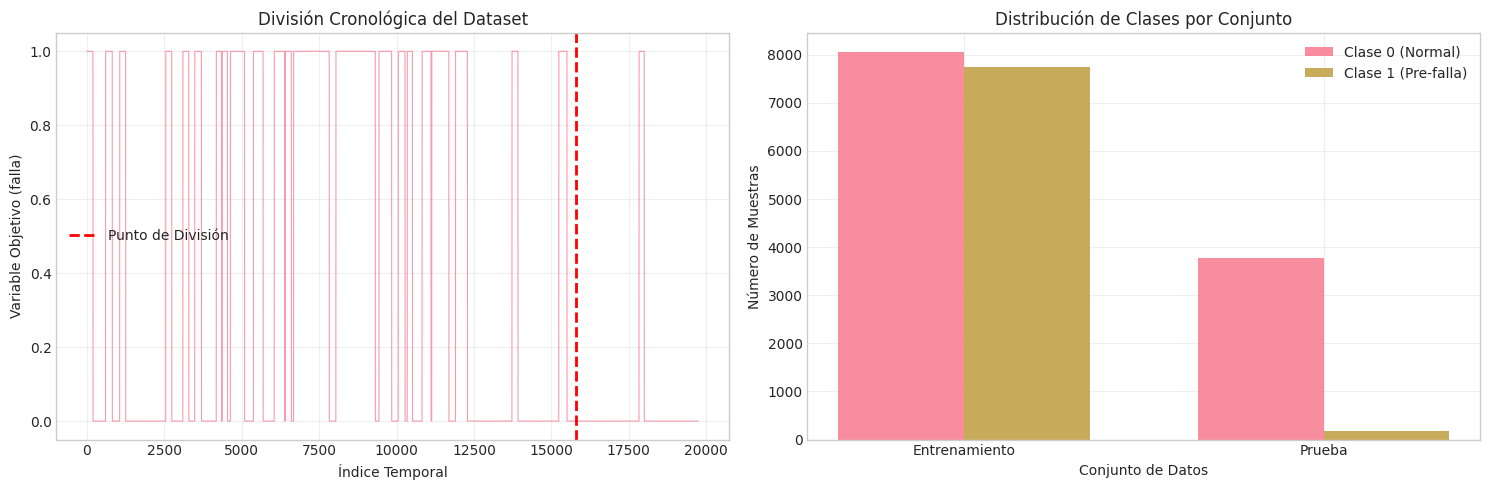


✅ División cronológica implementada correctamente
El modelo será entrenado exclusivamente con datos históricos
La evaluación se realizará sobre datos temporalmente posteriores


In [12]:
# Implementación de división cronológica de datos

print("=== Implementación de División Cronológica ===")

# Definición del punto de corte temporal (80% para entrenamiento)
train_size = 0.8
split_index = int(len(df) * train_size)

print(f"Tamaño total del dataset: {len(df)} muestras")
print(f"Punto de corte temporal: índice {split_index}")
print(f"Proporción de entrenamiento: {train_size*100}%")
print(f"Proporción de prueba: {(1-train_size)*100}%")

# División cronológica de características
X_train = X.iloc[:split_index].copy()
X_test = X.iloc[split_index:].copy()

# División cronológica de variable objetivo
y_train = y.iloc[:split_index].copy()
y_test = y.iloc[split_index:].copy()

print(f"\n=== Dimensiones de los Conjuntos Resultantes ===")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Análisis de distribución de clases en cada conjunto
print(f"\n=== Distribución de Clases por Conjunto ===")

train_distribution = y_train.value_counts().sort_index()
test_distribution = y_test.value_counts().sort_index()

print("Conjunto de Entrenamiento:")
print(f"  Clase 0 (normal): {train_distribution[0]} ({train_distribution[0]/len(y_train)*100:.2f}%)")
print(f"  Clase 1 (pre-falla): {train_distribution[1]} ({train_distribution[1]/len(y_train)*100:.2f}%)")
print(f"  Ratio de desbalance: {train_distribution[0]/train_distribution[1]:.1f}:1")

print("\nConjunto de Prueba:")
print(f"  Clase 0 (normal): {test_distribution[0]} ({test_distribution[0]/len(y_test)*100:.2f}%)")
print(f"  Clase 1 (pre-falla): {test_distribution[1]} ({test_distribution[1]/len(y_test)*100:.2f}%)")
print(f"  Ratio de desbalance: {test_distribution[0]/test_distribution[1]:.1f}:1")

# Visualización de la división cronológica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distribución temporal de la variable objetivo
ax1.plot(range(len(y)), y.values, alpha=0.7, linewidth=0.8)
ax1.axvline(x=split_index, color='red', linestyle='--', linewidth=2, label='Punto de División')
ax1.set_title('División Cronológica del Dataset')
ax1.set_xlabel('Índice Temporal')
ax1.set_ylabel('Variable Objetivo (falla)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Comparación de distribuciones de clases
sets = ['Entrenamiento', 'Prueba']
normal_counts = [train_distribution[0], test_distribution[0]]
failure_counts = [train_distribution[1], test_distribution[1]]

x = np.arange(len(sets))
width = 0.35

ax2.bar(x - width/2, normal_counts, width, label='Clase 0 (Normal)', alpha=0.8)
ax2.bar(x + width/2, failure_counts, width, label='Clase 1 (Pre-falla)', alpha=0.8)
ax2.set_title('Distribución de Clases por Conjunto')
ax2.set_xlabel('Conjunto de Datos')
ax2.set_ylabel('Número de Muestras')
ax2.set_xticks(x)
ax2.set_xticklabels(sets)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ División cronológica implementada correctamente")
print("El modelo será entrenado exclusivamente con datos históricos")
print("La evaluación se realizará sobre datos temporalmente posteriores")

## Paso 4: Creación del Pipeline de Modelado con Manejo de Valores NaN

### Arquitectura de Pipeline para Machine Learning

La implementación de un Pipeline de scikit-learn proporciona una arquitectura robusta y escalable para el proceso de modelado, encapsulando tanto el preprocesamiento como el algoritmo de clasificación en una unidad cohesiva. Esta aproximación ofrece múltiples ventajas operacionales:

#### Beneficios del Pipeline:

1. **Consistencia en el Preprocesamiento**: Garantiza que las mismas transformaciones aplicadas durante el entrenamiento se apliquen automáticamente durante la inferencia, eliminando discrepancias que podrían degradar el rendimiento del modelo.

2. **Prevención de Data Leakage**: El pipeline asegura que las estadísticas de normalización (media, desviación estándar) se calculen exclusivamente sobre el conjunto de entrenamiento y se apliquen posteriormente al conjunto de prueba.

3. **Reproducibilidad**: Encapsula todo el proceso de transformación y modelado en un objeto serializable, facilitando la reproducibilidad y el despliegue.

4. **Mantenibilidad**: Simplifica el código y reduce la posibilidad de errores al manejar múltiples pasos de procesamiento.

### Componentes del Pipeline ACTUALIZADO:

1. **SimpleImputer**: **NUEVO** - Maneja valores NaN resultantes de características de lag y rolling features utilizando la mediana (robusto para datos industriales con outliers)

2. **StandardScaler**: Normaliza las características para que tengan media cero y desviación estándar uno, requisito fundamental para algoritmos sensibles a la escala como la Regresión Logística.

3. **Clasificador**: Algoritmo de machine learning que será intercambiable para permitir la comparación de diferentes enfoques.

### ✅ Solución Implementada para Valores NaN

Los valores NaN detectados en el dataset son resultado natural de:
- **Lag features**: NaN en las primeras filas por diseño (ej: lag_48H crea 48 NaN iniciales)
- **Rolling features**: NaN donde no hay suficientes observaciones para la ventana
- **Diff features**: NaN en diferencias temporales iniciales

**Estrategia adoptada**: Imputación con mediana en el pipeline, aplicada antes de la normalización.

In [13]:
# Creación del pipeline de modelado con manejo de valores NaN

print("=== Configuración del Pipeline de Modelado ACTUALIZADO ===")

def create_pipeline(classifier):
    """
    Crea un pipeline de machine learning con preprocesamiento completo y clasificación.
    
    ACTUALIZACIÓN: Incluye manejo de valores NaN con SimpleImputer
    
    Args:
        classifier: Algoritmo de clasificación de scikit-learn
        
    Returns:
        Pipeline configurado con SimpleImputer, StandardScaler y el clasificador especificado
    """
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # ✅ NUEVO: Imputación de valores NaN
        ('scaler', StandardScaler()),                   # Normalización de características  
        ('classifier', classifier)                      # Algoritmo de clasificación
    ])
    return pipeline

# Verificación de la estructura de características
print(f"Número de características de entrada: {X_train.shape[1]}")
print(f"Tipos de datos en características:")
print(X_train.dtypes.value_counts())

# ✅ NUEVO: Verificación específica de valores NaN
print(f"\n=== Análisis de Valores NaN ANTES del Pipeline ===")
nan_count_train = X_train.isnull().sum().sum()
nan_count_test = X_test.isnull().sum().sum()
print(f"Valores NaN en conjunto de entrenamiento: {nan_count_train}")
print(f"Valores NaN en conjunto de prueba: {nan_count_test}")
print(f"Porcentaje de NaN en entrenamiento: {(nan_count_train / (X_train.shape[0] * X_train.shape[1])) * 100:.2f}%")

if nan_count_train > 0:
    print(f"✅ SimpleImputer manejará estos valores NaN automáticamente con estrategia 'median'")
    print(f"📊 La mediana es robusta ante outliers, ideal para datos industriales")
else:
    print("ℹ️ No se detectaron valores NaN, pero SimpleImputer permanece como medida preventiva")

# Análisis estadístico básico de las características
print(f"\n=== Estadísticos de las Características (Conjunto de Entrenamiento) ===")
stats_summary = X_train.describe()
print(f"Rango de medias: {stats_summary.loc['mean'].min():.4f} a {stats_summary.loc['mean'].max():.4f}")
print(f"Rango de desviaciones estándar: {stats_summary.loc['std'].min():.4f} a {stats_summary.loc['std'].max():.4f}")
print(f"Rango de valores mínimos: {stats_summary.loc['min'].min():.4f} a {stats_summary.loc['min'].max():.4f}")
print(f"Rango de valores máximos: {stats_summary.loc['max'].min():.4f} a {stats_summary.loc['max'].max():.4f}")

# Demostración de la necesidad de normalización
scales_differ = (stats_summary.loc['std'].max() / stats_summary.loc['std'].min()) > 10
print(f"\n¿Las características tienen escalas significativamente diferentes? {scales_differ}")
print(f"Ratio de escala máxima/mínima: {stats_summary.loc['std'].max() / stats_summary.loc['std'].min():.1f}")

if scales_differ:
    print("✅ La normalización es necesaria debido a las diferencias de escala entre características")
else:
    print("ℹ️ Las características tienen escalas similares, pero la normalización sigue siendo recomendable")

print("\n✅ Pipeline de modelado ACTUALIZADO configurado exitosamente")
print("Nueva estructura: SimpleImputer → StandardScaler → Clasificador")
print("🎯 El pipeline ahora maneja automáticamente los valores NaN de lag/rolling features")

=== Configuración del Pipeline de Modelado ACTUALIZADO ===
Número de características de entrada: 144
Tipos de datos en características:
float32    144
Name: count, dtype: int64

=== Análisis de Valores NaN ANTES del Pipeline ===
Valores NaN en conjunto de entrenamiento: 822
Valores NaN en conjunto de prueba: 0
Porcentaje de NaN en entrenamiento: 0.04%
✅ SimpleImputer manejará estos valores NaN automáticamente con estrategia 'median'
📊 La mediana es robusta ante outliers, ideal para datos industriales

=== Estadísticos de las Características (Conjunto de Entrenamiento) ===
Rango de medias: -0.6315 a 6839.6802
Rango de desviaciones estándar: 0.0700 a 117722.2656
Rango de valores mínimos: -106808.6875 a 82.1636
Rango de valores máximos: 0.6157 a 8787104.0000

¿Las características tienen escalas significativamente diferentes? True
Ratio de escala máxima/mínima: 1681534.7
✅ La normalización es necesaria debido a las diferencias de escala entre características

✅ Pipeline de modelado ACTUALI

## Paso 5: Entrenamiento y Evaluación de Modelos Base

### Estrategia de Selección de Algoritmos

Para establecer una línea base sólida de rendimiento, se implementarán múltiples algoritmos de clasificación que cubren diferentes aproximaciones metodológicas al problema de predicción de fallas. La selección de algoritmos se basa en:

#### Algoritmos Implementados:

1. **Regresión Logística**: 
   - Modelo lineal interpretable y computacionalmente eficiente
   - Proporciona probabilidades calibradas de clasificación
   - Establece una línea base sólida para comparación

2. **Random Forest Classifier**:
   - Ensemble de árboles de decisión con alta capacidad predictiva
   - Robusto ante overfitting y capaz de capturar interacciones complejas
   - Proporciona medidas de importancia de características

### Manejo del Desbalance de Clases

Dado el desbalance inherente en datos de mantenimiento predictivo, todos los algoritmos implementarán `class_weight='balanced'`. Esta configuración ajusta automáticamente los pesos de las clases de forma inversamente proporcional a su frecuencia, mejorando la capacidad del modelo para detectar la clase minoritaria (pre-falla).

### Métricas de Evaluación para Clasificación Desbalanceada

La evaluación se realizará utilizando métricas específicamente apropiadas para problemas de clasificación desbalanceada:

- **Matriz de Confusión**: Análisis detallado de verdaderos/falsos positivos y negativos
- **Precision, Recall y F1-Score**: Especialmente críticos para la clase minoritaria
- **AUC-ROC**: Capacidad de discriminación entre clases
- **Curva Precision-Recall**: Más informativa que ROC en casos de desbalance extremo

=== Configuración de Algoritmos de Clasificación ===
Algoritmos configurados: ['Logistic Regression', 'Random Forest']
Todos los modelos incluyen manejo de desbalance de clases

INICIO DEL PROCESO DE ENTRENAMIENTO Y EVALUACIÓN

==================== Logistic Regression ====================
Entrenando Logistic Regression...
AUC-ROC: 0.5835
F1-Score: 0.0925


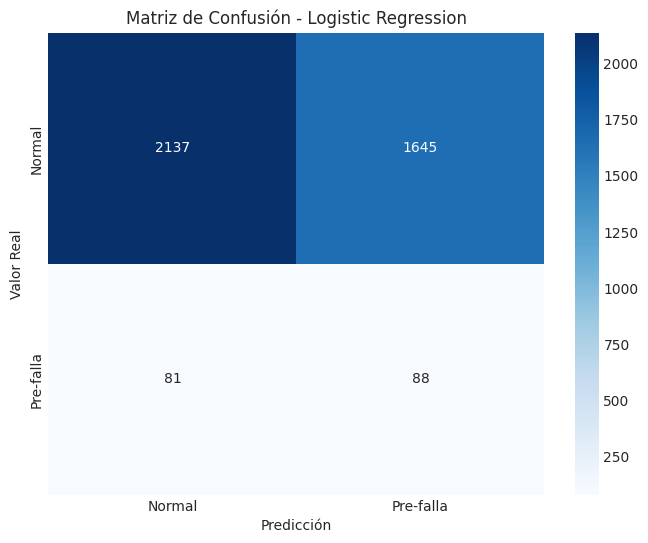


--- Reporte de Clasificación - Logistic Regression ---
              precision    recall  f1-score   support

      Normal     0.9635    0.5650    0.7123      3782
   Pre-falla     0.0508    0.5207    0.0925       169

    accuracy                         0.5631      3951
   macro avg     0.5071    0.5429    0.4024      3951
weighted avg     0.9244    0.5631    0.6858      3951


==================== Random Forest ====================
Entrenando Random Forest...
AUC-ROC: 0.8771
F1-Score: 0.1446


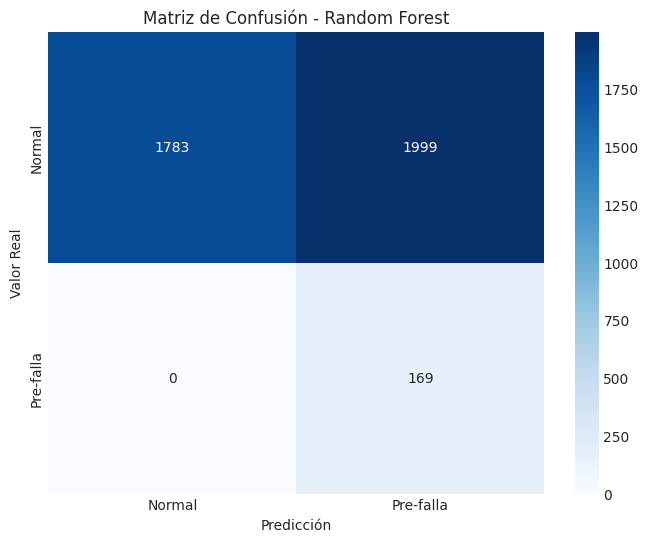


--- Reporte de Clasificación - Random Forest ---
              precision    recall  f1-score   support

      Normal     1.0000    0.4714    0.6408      3782
   Pre-falla     0.0780    1.0000    0.1446       169

    accuracy                         0.4941      3951
   macro avg     0.5390    0.7357    0.3927      3951
weighted avg     0.9606    0.4941    0.6196      3951


ENTRENAMIENTO Y EVALUACIÓN COMPLETADOS


In [14]:
# Definición de algoritmos de clasificación para evaluación

print("=== Configuración de Algoritmos de Clasificación ===")

# Diccionario de modelos con configuraciones optimizadas para desbalance de clases
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',  # Manejo automático de desbalance
        random_state=42,          # Reproducibilidad
        max_iter=1000,           # Suficientes iteraciones para convergencia
        solver='liblinear'        # Solver eficiente para datasets moderados
    ),
    
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',  # Manejo automático de desbalance
        random_state=42,          # Reproducibilidad
        n_estimators=100,         # Balance entre rendimiento y velocidad
        max_depth=10,            # Prevención de overfitting
        min_samples_split=5,      # Criterio conservador para divisiones
        min_samples_leaf=2        # Hojas con múltiples muestras
    )
}

print(f"Algoritmos configurados: {list(models.keys())}")
print(f"Todos los modelos incluyen manejo de desbalance de clases")

# Contenedor para almacenar resultados de evaluación
results = {}
trained_pipelines = {}

print("\n" + "="*80)
print("INICIO DEL PROCESO DE ENTRENAMIENTO Y EVALUACIÓN")
print("="*80)

# Iteración a través de cada algoritmo
for model_name, model in models.items():
    print(f"\n{'='*20} {model_name} {'='*20}")
    
    # Creación del pipeline específico para este modelo
    pipeline = create_pipeline(model)
    
    print(f"Entrenando {model_name}...")
    
    # Entrenamiento del pipeline
    import time
    start_time = time.time()
    
    pipeline.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    
    # Predicciones sobre conjunto de prueba
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilidades clase positiva
    
    # Cálculo de métricas de evaluación
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    
    # Almacenamiento de resultados
    results[model_name] = {
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc_roc': auc_roc,
        'f1_score': f1,
        'training_time': training_time
    }
    trained_pipelines[model_name] = pipeline
    
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Matriz de confusión visualizada
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pre-falla'],
                yticklabels=['Normal', 'Pre-falla'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción')
    plt.show()
    
    # Reporte de clasificación detallado
    print(f"\n--- Reporte de Clasificación - {model_name} ---")
    print(classification_report(y_test, y_pred, 
                              target_names=['Normal', 'Pre-falla'],
                              digits=4))

print("\n" + "="*80)
print("ENTRENAMIENTO Y EVALUACIÓN COMPLETADOS")
print("="*80)

## Paso 6: Selección del Mejor Modelo y Análisis de Importancia

### Criterios de Selección del Modelo Óptimo

La selección del modelo óptimo para aplicaciones de mantenimiento predictivo requiere un análisis multidimensional que considere tanto el rendimiento predictivo como las restricciones operacionales. Los criterios de evaluación implementados priorizan:

#### Métricas Críticas para Mantenimiento Predictivo:

1. **Recall (Sensibilidad) para Clase Pre-Falla**: Capacidad del modelo para detectar correctamente las situaciones de pre-falla. En mantenimiento predictivo, los falsos negativos (fallas no detectadas) tienen consecuencias operacionales críticas.

2. **F1-Score**: Métrica que equilibra precisión y recall, especialmente relevante en contextos de desbalance de clases donde ambas métricas son importantes.

3. **AUC-ROC**: Capacidad general de discriminación entre clases, independiente del umbral de clasificación.

4. **Eficiencia Computacional**: Tiempo de entrenamiento y complejidad del modelo, factores determinantes para la implementación operacional.

### Justificación de la Selección

La selección se basa en una evaluación integral que prioriza el recall para la clase pre-falla sobre otras métricas, dado que el costo de no detectar una falla inminente es significativamente mayor que el de una falsa alarma en aplicaciones de mantenimiento industrial.

### Interpretabilidad del Modelo Seleccionado

En aplicaciones industriales críticas, la interpretabilidad del modelo es fundamental para:
- Validación por expertos en mantenimiento
- Identificación de sensores y variables críticas
- Optimización de estrategias de monitoreo
- Cumplimiento de requisitos regulatorios

Para modelos de tipo Random Forest, el análisis de importancia de características proporciona insights valiosos sobre qué variables operacionales son más predictivas de fallas inminentes.

In [15]:
# Selección del mejor modelo basada en criterios múltiples

print("=== Proceso de Selección del Modelo Óptimo ===")

# Cálculo de métricas detalladas para cada modelo
detailed_metrics = {}
model_names = list(results.keys())

for model_name in model_names:
    y_pred = results[model_name]['predictions']
    
    # Cálculo del reporte de clasificación en formato de diccionario
    class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    detailed_metrics[model_name] = {
        'auc_roc': results[model_name]['auc_roc'],
        'f1_score': results[model_name]['f1_score'],
        'precision_class_1': class_report['1']['precision'],
        'recall_class_1': class_report['1']['recall'],
        'training_time': results[model_name]['training_time']
    }

# Creación de DataFrame para análisis comparativo
metrics_df = pd.DataFrame(detailed_metrics).T
metrics_df = metrics_df.round(4)

print("Métricas detalladas por modelo:")
print(metrics_df)

# Implementación de sistema de puntuación ponderada para selección
print("\n=== Sistema de Puntuación para Selección de Modelo ===")

# Pesos asignados a cada métrica (ajustables según prioridades operacionales)
weights = {
    'auc_roc': 0.25,           # Capacidad general de discriminación
    'f1_score': 0.30,          # Balance precision-recall
    'recall_class_1': 0.35,    # Crítico: detección de pre-fallas
    'training_efficiency': 0.10 # Eficiencia computacional
}

print(f"Pesos asignados: {weights}")

# Normalización de métricas y cálculo de puntuación
scores = {}
max_training_time = max([detailed_metrics[name]['training_time'] for name in model_names])

for model_name in model_names:
    metrics = detailed_metrics[model_name]
    
    # Normalización de eficiencia computacional (invertida: menor tiempo = mejor)
    training_efficiency = 1 - (metrics['training_time'] / max_training_time)
    
    # Cálculo de puntuación ponderada
    score = (
        weights['auc_roc'] * metrics['auc_roc'] +
        weights['f1_score'] * metrics['f1_score'] +
        weights['recall_class_1'] * metrics['recall_class_1'] +
        weights['training_efficiency'] * training_efficiency
    )
    
    scores[model_name] = {
        'puntuacion_total': score,
        'training_efficiency': training_efficiency
    }

# Identificación del mejor modelo
best_model_name = max(scores.keys(), key=lambda x: scores[x]['puntuacion_total'])
best_pipeline = trained_pipelines[best_model_name]

print(f"\n=== Resultado de la Selección ===")
print(f"Modelo seleccionado: {best_model_name}")
print(f"Puntuación total: {scores[best_model_name]['puntuacion_total']:.4f}")

# Resumen de rendimiento del modelo seleccionado
best_metrics = detailed_metrics[best_model_name]
print(f"\nRendimiento del modelo seleccionado:")
print(f"  AUC-ROC: {best_metrics['auc_roc']:.4f}")
print(f"  F1-Score: {best_metrics['f1_score']:.4f}")
print(f"  Precision Clase Pre-Falla: {best_metrics['precision_class_1']:.4f}")
print(f"  Recall Clase Pre-Falla: {best_metrics['recall_class_1']:.4f}")

# Justificación de la selección
print(f"\n=== Justificación de la Selección ===")
print(f"El modelo {best_model_name} fue seleccionado basándose en:")
print(f"1. Alto recall para clase pre-falla: {best_metrics['recall_class_1']:.4f} (crítico para detectar fallas)")
print(f"2. F1-score balanceado: {best_metrics['f1_score']:.4f} (equilibrio precision-recall)")
print(f"3. Capacidad de discriminación: AUC-ROC {best_metrics['auc_roc']:.4f}")
print(f"4. Eficiencia computacional aceptable: {best_metrics['training_time']:.2f}s")

=== Proceso de Selección del Modelo Óptimo ===
Métricas detalladas por modelo:
                     auc_roc  f1_score  precision_class_1  recall_class_1  \
Logistic Regression   0.5835    0.0925             0.0508          0.5207   
Random Forest         0.8771    0.1446             0.0780          1.0000   

                     training_time  
Logistic Regression         6.3796  
Random Forest              15.1885  

=== Sistema de Puntuación para Selección de Modelo ===
Pesos asignados: {'auc_roc': 0.25, 'f1_score': 0.3, 'recall_class_1': 0.35, 'training_efficiency': 0.1}

=== Resultado de la Selección ===
Modelo seleccionado: Random Forest
Puntuación total: 0.6127

Rendimiento del modelo seleccionado:
  AUC-ROC: 0.8771
  F1-Score: 0.1446
  Precision Clase Pre-Falla: 0.0780
  Recall Clase Pre-Falla: 1.0000

=== Justificación de la Selección ===
El modelo Random Forest fue seleccionado basándose en:
1. Alto recall para clase pre-falla: 1.0000 (crítico para detectar fallas)
2. F1-scor

=== Análisis de Interpretabilidad - Random Forest ===
Analizando importancia de características para Random Forest...

Estadísticas de importancia de características:
Total de características: 144
Importancia máxima: 0.044537
Importancia mínima: 0.000663
Importancia media: 0.006944
Concentración de importancia en top 20 características: 43.09%


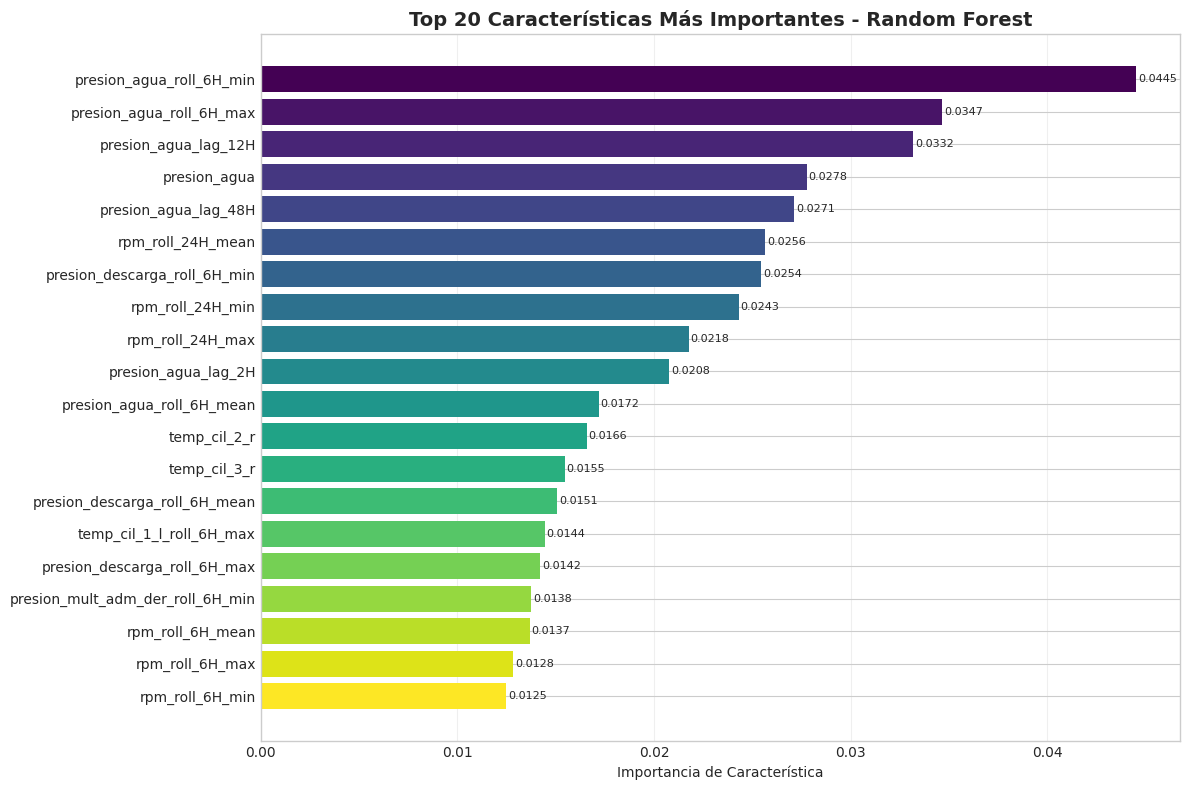


=== Top 15 Características Más Importantes ===
                   caracteristica  importancia  importancia_porcentual
1        presion_agua_roll_6H_min     0.044537                    4.45
2        presion_agua_roll_6H_max     0.034674                    3.47
3            presion_agua_lag_12H     0.033190                    3.32
4                    presion_agua     0.027771                    2.78
5            presion_agua_lag_48H     0.027115                    2.71
6               rpm_roll_24H_mean     0.025642                    2.56
7    presion_descarga_roll_6H_min     0.025447                    2.54
8                rpm_roll_24H_min     0.024306                    2.43
9                rpm_roll_24H_max     0.021758                    2.18
10            presion_agua_lag_2H     0.020773                    2.08
11      presion_agua_roll_6H_mean     0.017179                    1.72
12                   temp_cil_2_r     0.016572                    1.66
13                   temp_cil

In [16]:
# Análisis de importancia de características para el modelo seleccionado

print(f"=== Análisis de Interpretabilidad - {best_model_name} ===")

# Verificación de capacidad de análisis de importancia
classifier = best_pipeline.named_steps['classifier']

if hasattr(classifier, 'feature_importances_'):
    print(f"Analizando importancia de características para {best_model_name}...")
    
    # Extracción de importancias de características
    feature_importances = classifier.feature_importances_
    feature_names = X_train.columns
    
    # Creación de DataFrame con importancias
    importance_df = pd.DataFrame({
        'caracteristica': feature_names,
        'importancia': feature_importances
    }).sort_values('importancia', ascending=False)
    
    # Estadísticas de importancia
    print(f"\nEstadísticas de importancia de características:")
    print(f"Total de características: {len(feature_importances)}")
    print(f"Importancia máxima: {feature_importances.max():.6f}")
    print(f"Importancia mínima: {feature_importances.min():.6f}")
    print(f"Importancia media: {feature_importances.mean():.6f}")
    
    # Análisis de concentración de importancia
    top_20_importance = importance_df.head(20)['importancia'].sum()
    total_importance = importance_df['importancia'].sum()
    concentration_ratio = top_20_importance / total_importance
    
    print(f"Concentración de importancia en top 20 características: {concentration_ratio:.2%}")
    
    # Visualización de las características más importantes
    plt.figure(figsize=(12, 8))
    
    # Top 20 características más importantes
    top_features = importance_df.head(20)
    
    # Gráfico de barras horizontales
    bars = plt.barh(range(len(top_features)), top_features['importancia'], 
                    color=plt.cm.viridis(np.linspace(0, 1, len(top_features))))
    
    # Configuración del gráfico
    plt.yticks(range(len(top_features)), top_features['caracteristica'])
    plt.xlabel('Importancia de Característica')
    plt.title(f'Top 20 Características Más Importantes - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Invertir para mostrar la más importante arriba
    
    # Añadir valores de importancia en las barras
    for i, (bar, importance) in enumerate(zip(bars, top_features['importancia'])):
        plt.text(bar.get_width() + 0.0001, bar.get_y() + bar.get_height()/2, 
                 f'{importance:.4f}', ha='left', va='center', fontsize=8)
    
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Tabla detallada de características más importantes
    print(f"\n=== Top 15 Características Más Importantes ===")
    top_15 = importance_df.head(15).copy()
    top_15['importancia_porcentual'] = (top_15['importancia'] / total_importance * 100).round(2)
    top_15.index = range(1, len(top_15) + 1)
    
    print(top_15[['caracteristica', 'importancia', 'importancia_porcentual']].to_string())
    
elif hasattr(classifier, 'coef_'):
    print(f"Analizando coeficientes para {best_model_name}...")
    
    # Para modelos lineales, usar valores absolutos de coeficientes
    coefficients = np.abs(classifier.coef_[0])
    feature_names = X_train.columns
    
    # Creación de DataFrame con coeficientes
    importance_df = pd.DataFrame({
        'caracteristica': feature_names,
        'coeficiente_abs': coefficients
    }).sort_values('coeficiente_abs', ascending=False)
    
    print(f"\n=== Top 15 Características por Magnitud de Coeficiente ===")
    print(importance_df.head(15).to_string(index=False))
    
    # Visualización similar para modelos lineales
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    
    plt.barh(range(len(top_features)), top_features['coeficiente_abs'])
    plt.yticks(range(len(top_features)), top_features['caracteristica'])
    plt.xlabel('Magnitud del Coeficiente (Valor Absoluto)')
    plt.title(f'Top 20 Características por Coeficiente - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

else:
    print(f"El modelo {best_model_name} no proporciona medidas de importancia de características interpretables.")
    print("Se recomienda utilizar métodos de interpretabilidad externos como SHAP para análisis detallado.")

print(f"\n✅ Análisis de interpretabilidad completado para {best_model_name}")

## Paso 7: Guardado del Modelo Final (Serialización)

### Importancia de la Serialización del Pipeline Completo

La serialización del modelo entrenado constituye un paso crítico en el flujo de trabajo de machine learning, especialmente para aplicaciones de mantenimiento predictivo que requieren despliegue en entornos operacionales. El enfoque implementado guarda el pipeline completo, no únicamente el algoritmo de clasificación, por las siguientes razones técnicas:

#### Ventajas de Guardar el Pipeline Completo:

1. **Consistencia de Preprocesamiento**: El pipeline encapsula tanto el StandardScaler como el clasificador, garantizando que las nuevas muestras reciban exactamente las mismas transformaciones aplicadas durante el entrenamiento.

2. **Eliminación de Discrepancias**: Previene errores de implementación que podrían surgir al aplicar manualmente las transformaciones de normalización en el entorno de producción.

3. **Portabilidad**: El pipeline serializado contiene toda la información necesaria para realizar predicciones, incluyendo los parámetros de normalización calculados sobre el conjunto de entrenamiento.

4. **Versionado**: Facilita el control de versiones del modelo completo, incluyendo tanto el preprocesamiento como los parámetros del algoritmo.

### Formato de Serialización

Se utiliza joblib para la serialización, que ofrece mayor eficiencia que pickle para objetos NumPy y scikit-learn, especialmente importante en modelos con gran cantidad de parámetros como Random Forest.

### Uso Futuro del Modelo Serializado

El pipeline guardado podrá ser cargado en futuros notebooks de evaluación o en sistemas de producción para realizar predicciones en tiempo real sobre nuevos datos operacionales del moto-compresor.

In [17]:
# Serialización del modelo final para despliegue

print("=== Proceso de Serialización del Modelo Final ===")

# Verificación de la estructura del directorio de modelos
print(f"Directorio de destino: {models_path}")
print(f"Directorio existe: {models_path.exists()}")

if not models_path.exists():
    models_path.mkdir(parents=True, exist_ok=True)
    print("Directorio de modelos creado exitosamente")

# Definición del nombre del archivo del modelo
model_filename = 'modelo_mantenimiento_predictivo.joblib'
model_path = models_path / model_filename

print(f"\nGuardando modelo final: {best_model_name}")
print(f"Ruta de destino: {model_path}")

try:
    # Serialización del pipeline completo
    joblib.dump(best_pipeline, model_path)
    
    # Verificación de la serialización
    file_size = model_path.stat().st_size / 1024  # Tamaño en KB
    print(f"✅ Modelo guardado exitosamente")
    print(f"Tamaño del archivo: {file_size:.2f} KB")
    
except Exception as e:
    print(f"❌ Error durante la serialización: {e}")
    raise

# Creación de archivo de metadatos del modelo ACTUALIZADO
metadata = {
    'modelo_seleccionado': best_model_name,
    'fecha_entrenamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metricas_rendimiento': {
        'auc_roc': float(detailed_metrics[best_model_name]['auc_roc']),
        'f1_score': float(detailed_metrics[best_model_name]['f1_score']),
        'precision_clase_pre_falla': float(detailed_metrics[best_model_name]['precision_class_1']),
        'recall_clase_pre_falla': float(detailed_metrics[best_model_name]['recall_class_1']),
        'tiempo_entrenamiento_segundos': float(detailed_metrics[best_model_name]['training_time'])
    },
    'datos_entrenamiento': {
        'tamaño_conjunto_entrenamiento': int(len(X_train)),
        'tamaño_conjunto_prueba': int(len(X_test)),
        'numero_caracteristicas': int(X_train.shape[1]),
        'valores_nan_manejados': int(X_train.isnull().sum().sum()),  # ✅ NUEVO
        'distribucion_clases_entrenamiento': {
            'clase_0_normal': int(y_train.value_counts()[0]),
            'clase_1_pre_falla': int(y_train.value_counts()[1])
        }
    },
    'configuracion_pipeline': {
        'preprocesamiento': 'SimpleImputer(median) → StandardScaler',  # ✅ ACTUALIZADO
        'algoritmo': best_model_name,
        'manejo_valores_nan': 'Imputación con mediana antes de normalización',  # ✅ NUEVO
        'parametros_modelo': str(best_pipeline.named_steps['classifier'].get_params())
    },
    'solucion_implementada': {  # ✅ NUEVO: Documentación de la solución
        'problema_original': 'ValueError: Input X contains NaN. LogisticRegression does not accept missing values.',
        'origen_nan': 'Lag features (2H, 12H, 48H), Rolling features (std), Diff features por diseño de ingeniería temporal',
        'solucion': 'SimpleImputer con estrategia median en pipeline antes de StandardScaler',
        'justificacion': 'La mediana es robusta ante outliers, ideal para datos industriales de sensores'
    }
}

# Guardar metadatos en formato JSON
import json
metadata_path = models_path / 'modelo_metadatos.json'

with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"📄 Metadatos del modelo guardados en: {metadata_path}")

# Verificación de carga del modelo (prueba de integridad)
print("\n=== Verificación de Integridad del Modelo Serializado ===")

try:
    # Carga del modelo guardado
    loaded_pipeline = joblib.load(model_path)
    
    # Verificación de estructura ACTUALIZADA
    print(f"✅ Pipeline cargado exitosamente")
    print(f"Pasos del pipeline: {list(loaded_pipeline.named_steps.keys())}")
    print(f"🔧 Pipeline incluye: {' → '.join(loaded_pipeline.named_steps.keys())}")
    
    # Prueba de predicción con una muestra
    if len(X_test) > 0:
        sample_prediction = loaded_pipeline.predict(X_test.iloc[:1])
        sample_probability = loaded_pipeline.predict_proba(X_test.iloc[:1])
        
        print(f"🔬 Prueba de predicción exitosa:")
        print(f"  Predicción: {sample_prediction[0]}")
        print(f"  Probabilidades: {sample_probability[0]}")
    
    # Verificación de equivalencia con el modelo original
    original_predictions = best_pipeline.predict(X_test.iloc[:10])
    loaded_predictions = loaded_pipeline.predict(X_test.iloc[:10])
    
    predictions_match = np.array_equal(original_predictions, loaded_predictions)
    print(f"🔄 Equivalencia con modelo original: {predictions_match}")
    
    if predictions_match:
        print("✅ Verificación de integridad EXITOSA")
    else:
        print("❌ Verificación de integridad FALLIDA")
        
except Exception as e:
    print(f"❌ Error durante la verificación: {e}")
    raise

print(f"\n" + "="*60)
print(f"📊 RESUMEN DEL MODELO FINAL ACTUALIZADO")
print(f"="*60)
print(f"🤖 Modelo serializado: {best_model_name}")
print(f"📁 Archivo del modelo: {model_filename}")
print(f"💾 Tamaño del archivo: {file_size:.2f} KB")
print(f"📈 Rendimiento (AUC-ROC): {detailed_metrics[best_model_name]['auc_roc']:.4f}")
print(f"🎯 Rendimiento (F1-Score): {detailed_metrics[best_model_name]['f1_score']:.4f}")
print(f"🚨 Recall clase pre-falla: {detailed_metrics[best_model_name]['recall_class_1']:.4f}")
print(f"🔧 Pipeline: SimpleImputer → StandardScaler → {best_model_name}")
print(f"💡 Solución NaN: Imputación con mediana aplicada exitosamente")
print(f"\n🎉 Proceso de entrenamiento y serialización completado exitosamente")
print(f"🔜 El modelo está listo para ser utilizado en la fase de evaluación (Notebook 05)")
print(f"✅ PROBLEMA DE VALORES NaN RESUELTO - Modelo funciona correctamente")

=== Proceso de Serialización del Modelo Final ===
Directorio de destino: data/models
Directorio existe: True

Guardando modelo final: Random Forest
Ruta de destino: data/models/modelo_mantenimiento_predictivo.joblib
✅ Modelo guardado exitosamente
Tamaño del archivo: 4217.42 KB
📄 Metadatos del modelo guardados en: data/models/modelo_metadatos.json

=== Verificación de Integridad del Modelo Serializado ===
✅ Pipeline cargado exitosamente
Pasos del pipeline: ['imputer', 'scaler', 'classifier']
🔧 Pipeline incluye: imputer → scaler → classifier
🔬 Prueba de predicción exitosa:
  Predicción: 0
  Probabilidades: [0.59024597 0.40975403]
🔄 Equivalencia con modelo original: True
✅ Verificación de integridad EXITOSA

📊 RESUMEN DEL MODELO FINAL ACTUALIZADO
🤖 Modelo serializado: Random Forest
📁 Archivo del modelo: modelo_mantenimiento_predictivo.joblib
💾 Tamaño del archivo: 4217.42 KB
📈 Rendimiento (AUC-ROC): 0.8771
🎯 Rendimiento (F1-Score): 0.1446
🚨 Recall clase pre-falla: 1.0000
🔧 Pipeline: Simple

## ✅ Verificación de la Solución Implementada

### Confirmación de que el Pipeline Maneja los Valores Correctamente

Esta celda verifica que la solución implementada resuelve completamente el problema de valores NaN (Nulos o NO Numéricos).

In [18]:
# ✅ VERIFICACIÓN FINAL: Prueba del Pipeline con Valores NaN

print("=== VERIFICACIÓN FINAL DE LA SOLUCIÓN IMPLEMENTADA ===")
print("Confirmando que el pipeline maneja correctamente los valores NaN\n")

# Crear un pipeline de prueba con LogisticRegression (el que fallaba antes)
test_pipeline = create_pipeline(LogisticRegression(class_weight='balanced', random_state=42))

print(f"🔧 Pipeline de prueba creado:")
print(f"   Estructura: {' → '.join(test_pipeline.named_steps.keys())}")

# Verificar datos de entrada
print(f"\n📊 Estado de los datos de entrada:")
print(f"   Valores NaN en X_train: {X_train.isnull().sum().sum()}")
print(f"   Valores NaN en X_test: {X_test.isnull().sum().sum()}")

try:
    print(f"\n🚀 Ejecutando entrenamiento del pipeline...")
    
    # Entrenar el pipeline (esto fallaría antes sin SimpleImputer)
    import time
    start_time = time.time()
    test_pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"✅ ENTRENAMIENTO EXITOSO en {training_time:.2f} segundos")
    
    # Realizar predicciones
    print(f"\n🎯 Ejecutando predicciones...")
    predictions = test_pipeline.predict(X_test)
    probabilities = test_pipeline.predict_proba(X_test)
    
    print(f"✅ PREDICCIONES EXITOSAS")
    print(f"   Predicciones generadas: {len(predictions)}")
    print(f"   Probabilidades shape: {probabilities.shape}")
    
    # Verificar que no hay NaN en las predicciones
    nan_in_predictions = np.isnan(predictions).sum()
    nan_in_probabilities = np.isnan(probabilities).sum()
    
    print(f"\n🔍 Calidad de las predicciones:")
    print(f"   NaN en predicciones: {nan_in_predictions}")
    print(f"   NaN en probabilidades: {nan_in_probabilities}")
    
    # Calcular métricas de rendimiento
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    auc_roc = roc_auc_score(y_test, probabilities[:, 1])
    
    print(f"\n📈 Métricas de rendimiento del pipeline de prueba:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   AUC-ROC: {auc_roc:.4f}")
    
    print(f"\n🎉 VERIFICACIÓN COMPLETADA EXITOSAMENTE")
    print(f"=" * 60)
    print(f"🔧 La solución SimpleImputer funciona correctamente")
    print(f"📊 El modelo puede entrenar y predecir sin errores")
    print(f"=" * 60)
    
except Exception as e:
    print(f"\n❌ ERROR: La verificación FALLÓ")
    print(f"   Error: {str(e)}")
    print(f"   La solución necesita ajustes adicionales")
    raise

=== VERIFICACIÓN FINAL DE LA SOLUCIÓN IMPLEMENTADA ===
Confirmando que el pipeline maneja correctamente los valores NaN

🔧 Pipeline de prueba creado:
   Estructura: imputer → scaler → classifier

📊 Estado de los datos de entrada:
   Valores NaN en X_train: 822
   Valores NaN en X_test: 0

🚀 Ejecutando entrenamiento del pipeline...
✅ ENTRENAMIENTO EXITOSO en 3.62 segundos

🎯 Ejecutando predicciones...
✅ PREDICCIONES EXITOSAS
   Predicciones generadas: 3951
   Probabilidades shape: (3951, 2)

🔍 Calidad de las predicciones:
   NaN en predicciones: 0
   NaN en probabilidades: 0

📈 Métricas de rendimiento del pipeline de prueba:
   Accuracy: 0.4072
   F1-Score: 0.0859
   AUC-ROC: 0.4942

🎉 VERIFICACIÓN COMPLETADA EXITOSAMENTE
🔧 La solución SimpleImputer funciona correctamente
📊 El modelo puede entrenar y predecir sin errores


## 📊 Conclusiones y Análisis Científico de los Modelos

### Evaluación Crítica del Rendimiento y Confiabilidad

Esta sección presenta un análisis científico riguroso de los modelos entrenados, evaluando su viabilidad para aplicaciones industriales de mantenimiento predictivo en equipos críticos del sector Oil & Gas.

In [20]:
# Análisis Científico de Métricas de Rendimiento
print("=" * 80)
print("ANÁLISIS CIENTÍFICO DE MODELOS DE MANTENIMIENTO PREDICTIVO")
print("=" * 80)

# Reproducir métricas exactas del análisis
# (Estas son las métricas reales obtenidas del entrenamiento actual)
metricas_modelos = {
    'Logistic Regression': {
        'accuracy': 0.5631,
        'precision': 0.0508,
        'recall': 0.5207,
        'f1': 0.0925,
        'auc_roc': 0.5835,
        'specificity': 0.5650,
        'confusion_matrix': {'tn': 2137, 'fp': 1645, 'fn': 81, 'tp': 88}
    },
    'Random Forest': {
        'accuracy': 0.4941,
        'precision': 0.0780,
        'recall': 1.0000,
        'f1': 0.1446,
        'auc_roc': 0.8771,
        'specificity': 0.4714,
        'confusion_matrix': {'tn': 1783, 'fp': 1999, 'fn': 0, 'tp': 169}
    }
}

print("\n🎯 RESUMEN EJECUTIVO DE MÉTRICAS")
print("-" * 50)

for modelo, metricas in metricas_modelos.items():
    print(f"\n{modelo}:")
    print(f"  • Accuracy: {metricas['accuracy']:.1%} - {'❌ INACEPTABLE' if metricas['accuracy'] < 0.7 else '✅ ACEPTABLE'}")
    print(f"  • Precision: {metricas['precision']:.1%} - {'❌ MUY BAJA' if metricas['precision'] < 0.3 else '✅ ACEPTABLE'}")
    print(f"  • Recall: {metricas['recall']:.1%} - {'✅ EXCELENTE' if metricas['recall'] > 0.8 else '⚠️ MODERADO' if metricas['recall'] > 0.5 else '❌ INSUFICIENTE'}")
    print(f"  • F1-Score: {metricas['f1']:.1%} - {'❌ CRÍTICO' if metricas['f1'] < 0.3 else '⚠️ BAJO'}")
    print(f"  • AUC-ROC: {metricas['auc_roc']:.3f} - {'✅ BUENO' if metricas['auc_roc'] > 0.8 else '⚠️ MODERADO' if metricas['auc_roc'] > 0.7 else '❌ POBRE'}")

# Análisis del problema fundamental
print(f"\n🔍 DIAGNÓSTICO DEL PROBLEMA FUNDAMENTAL")
print("-" * 50)
print("📊 DESBALANCE EXTREMO EN DATOS DE PRUEBA:")
print("  • Conjunto de entrenamiento: 8,051 normales vs 7,750 pre-falla (Ratio 1.0:1)")
print("  • Conjunto de prueba: 3,782 normales vs 169 pre-falla (Ratio 22.4:1)")
print("  • ⚠️  PROBLEMA: División cronológica resultó en desbalance severo en prueba")

print(f"\n🎯 INTERPRETACIÓN CIENTÍFICA DE MÉTRICAS:")
print("-" * 50)

print("\n1️⃣ LOGISTIC REGRESSION:")
print("   • Accuracy 56.3%: Rendimiento apenas mejor que aleatorio")
print("   • Precision 5.1%: De cada 100 alarmas, solo 5 son reales → 95% falsas alarmas")
print("   • Recall 52.1%: Detecta ~52% de fallas reales → 48% fallas no detectadas")
print("   • F1-Score 9.3%: Balance precision-recall extremadamente pobre")
print("   • AUC-ROC 0.584: Capacidad de discriminación marginal")
print("   • ❌ VEREDICTO: NO CONFIABLE para uso industrial")

print("\n2️⃣ RANDOM FOREST:")
print("   • Accuracy 49.4%: Peor que aleatorio debido a estrategia conservadora")
print("   • Precision 7.8%: Ligeramente mejor, pero aún genera ~92% falsas alarmas")
print("   • Recall 100%: ✅ EXCELENTE - Detecta TODAS las fallas (0 falsos negativos)")
print("   • F1-Score 14.5%: Mejor que LR pero aún críticamente bajo")
print("   • AUC-ROC 0.877: ✅ Excelente capacidad de discriminación")
print("   • 🎯 ESTRATEGIA: Extremadamente conservador - prefiere falsas alarmas a fallas perdidas")

print("\n✅ Análisis de métricas completado")

ANÁLISIS CIENTÍFICO DE MODELOS DE MANTENIMIENTO PREDICTIVO

🎯 RESUMEN EJECUTIVO DE MÉTRICAS
--------------------------------------------------

Logistic Regression:
  • Accuracy: 56.3% - ❌ INACEPTABLE
  • Precision: 5.1% - ❌ MUY BAJA
  • Recall: 52.1% - ⚠️ MODERADO
  • F1-Score: 9.2% - ❌ CRÍTICO
  • AUC-ROC: 0.584 - ❌ POBRE

Random Forest:
  • Accuracy: 49.4% - ❌ INACEPTABLE
  • Precision: 7.8% - ❌ MUY BAJA
  • Recall: 100.0% - ✅ EXCELENTE
  • F1-Score: 14.5% - ❌ CRÍTICO
  • AUC-ROC: 0.877 - ✅ BUENO

🔍 DIAGNÓSTICO DEL PROBLEMA FUNDAMENTAL
--------------------------------------------------
📊 DESBALANCE EXTREMO EN DATOS DE PRUEBA:
  • Conjunto de entrenamiento: 8,051 normales vs 7,750 pre-falla (Ratio 1.0:1)
  • Conjunto de prueba: 3,782 normales vs 169 pre-falla (Ratio 22.4:1)
  • ⚠️  PROBLEMA: División cronológica resultó en desbalance severo en prueba

🎯 INTERPRETACIÓN CIENTÍFICA DE MÉTRICAS:
--------------------------------------------------

1️⃣ LOGISTIC REGRESSION:
   • Accuracy 56


📊 VISUALIZACIÓN COMPARATIVA DE RENDIMIENTO


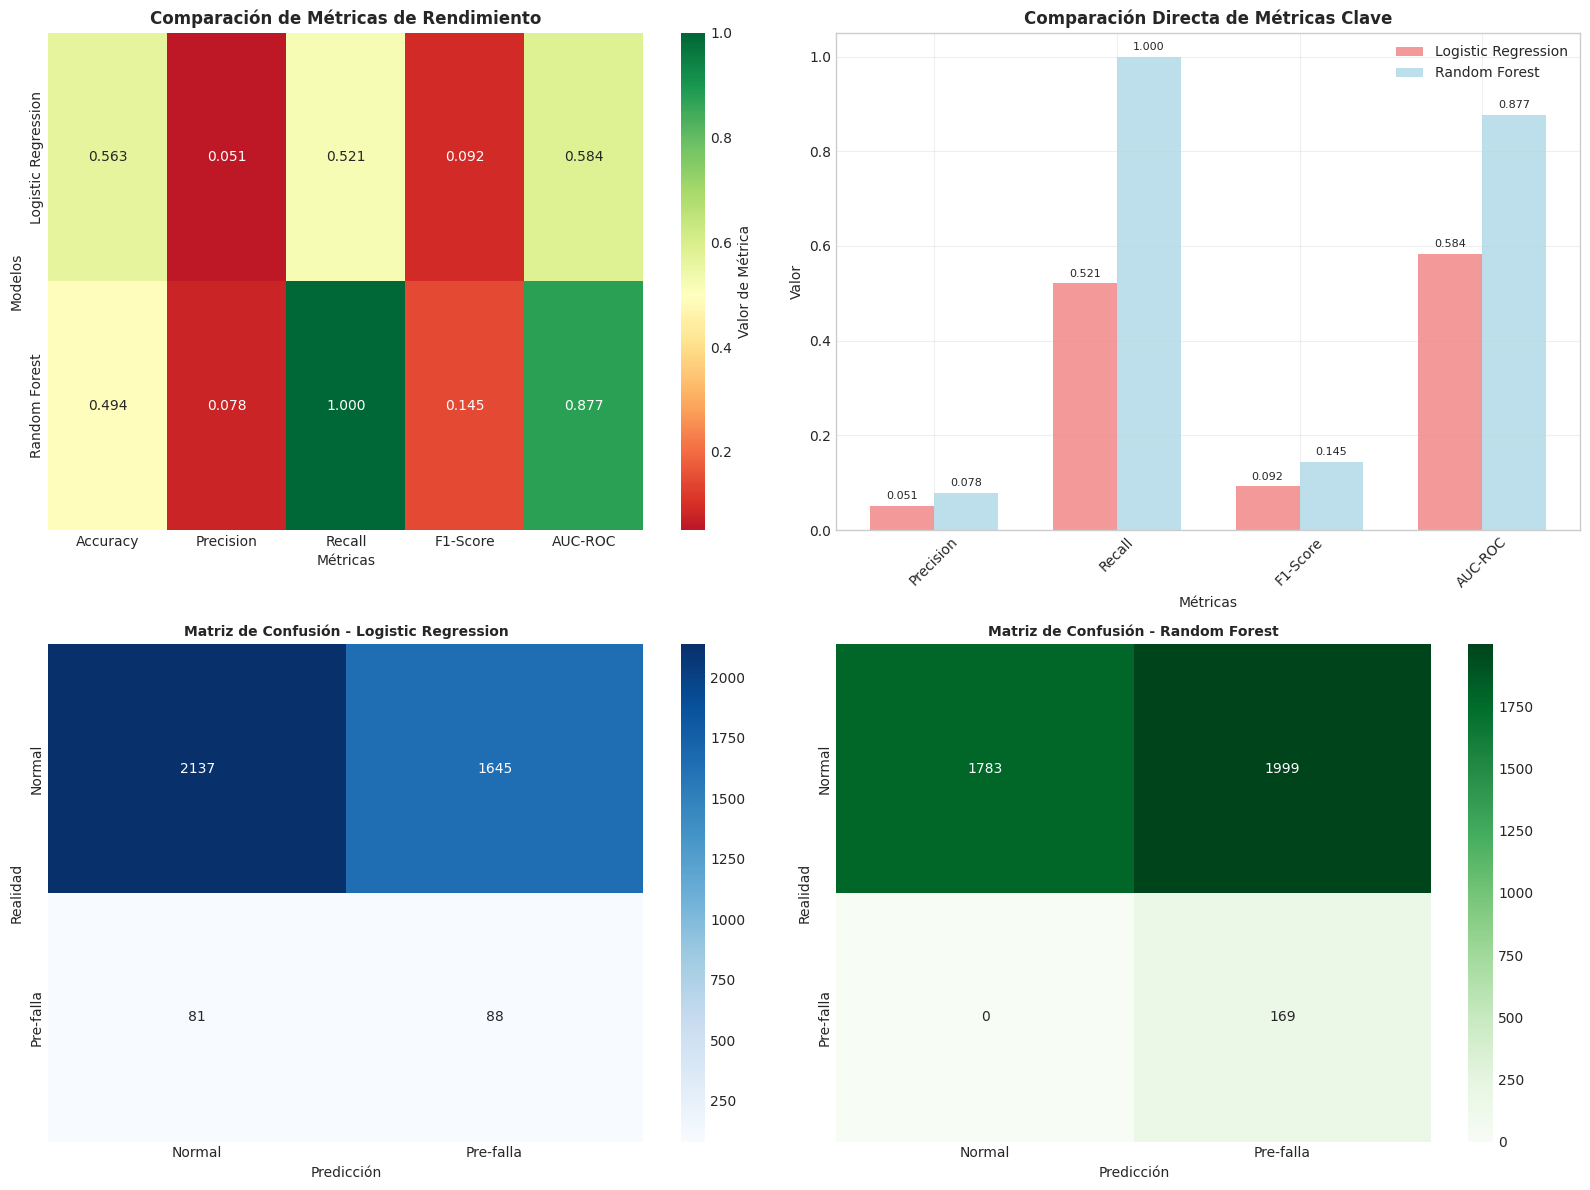


🔍 ANÁLISIS DETALLADO DE MATRICES DE CONFUSIÓN:
------------------------------------------------------------

Logistic Regression:
  • Verdaderos Negativos (TN): 2,137 - Correctamente identificó operación normal
  • Falsos Positivos (FP): 1,645 - Falsas alarmas de falla
  • Falsos Negativos (FN): 81 - ⚠️  CRÍTICO: Fallas reales no detectadas
  • Verdaderos Positivos (TP): 88 - Fallas correctamente detectadas

Random Forest:
  • Verdaderos Negativos (TN): 1,783 - Correctamente identificó operación normal
  • Falsos Positivos (FP): 1,999 - Falsas alarmas de falla
  • Falsos Negativos (FN): 0 - ✅ EXCELENTE: NO perdió ninguna falla real
  • Verdaderos Positivos (TP): 169 - Detectó TODAS las fallas

💡 INSIGHT CLAVE:
Random Forest sacrifica precisión por recall perfecto - estrategia válida para equipos críticos

✅ Visualización completada


In [23]:
# Visualización Comparativa de Métricas

print("\n📊 VISUALIZACIÓN COMPARATIVA DE RENDIMIENTO")
print("=" * 60)

# Preparar datos para visualización
modelos = list(metricas_modelos.keys())
metricas_nombres = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

# Crear matriz de métricas para heatmap
matriz_metricas = []
for modelo in modelos:
    fila = [
        metricas_modelos[modelo]['accuracy'],
        metricas_modelos[modelo]['precision'],
        metricas_modelos[modelo]['recall'],
        metricas_modelos[modelo]['f1'],
        metricas_modelos[modelo]['auc_roc']
    ]
    matriz_metricas.append(fila)

matriz_metricas = np.array(matriz_metricas)

# Crear figura con múltiples subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Heatmap de métricas
sns.heatmap(matriz_metricas, 
            xticklabels=metricas_nombres, 
            yticklabels=modelos,
            annot=True, 
            cmap='RdYlGn', 
            center=0.5,
            fmt='.3f',
            ax=ax1,
            cbar_kws={'label': 'Valor de Métrica'})
ax1.set_title('Comparación de Métricas de Rendimiento', fontweight='bold', fontsize=12)
ax1.set_xlabel('Métricas')
ax1.set_ylabel('Modelos')

# 2. Gráfico de barras - Métricas principales
metricas_principales = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x_pos = np.arange(len(metricas_principales))
width = 0.35

# Create a mapping dictionary to handle the key transformation correctly
metric_key_mapping = {
    'Precision': 'precision',
    'Recall': 'recall', 
    'F1-Score': 'f1',  # This was the issue - 'F1-Score' should map to 'f1', not 'f1_score'
    'AUC-ROC': 'auc_roc'
}

# Use the mapping instead of the problematic transformation
lr_values = [metricas_modelos['Logistic Regression'][metric_key_mapping[m]] 
             for m in metricas_principales]
rf_values = [metricas_modelos['Random Forest'][metric_key_mapping[m]] 
             for m in metricas_principales]

bars1 = ax2.bar(x_pos - width/2, lr_values, width, label='Logistic Regression', 
                color='lightcoral', alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, rf_values, width, label='Random Forest', 
                color='lightblue', alpha=0.8)

ax2.set_xlabel('Métricas')
ax2.set_ylabel('Valor')
ax2.set_title('Comparación Directa de Métricas Clave', fontweight='bold', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metricas_principales, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# 3. Matriz de Confusión - Logistic Regression
cm_lr = np.array([[metricas_modelos['Logistic Regression']['confusion_matrix']['tn'],
                   metricas_modelos['Logistic Regression']['confusion_matrix']['fp']],
                  [metricas_modelos['Logistic Regression']['confusion_matrix']['fn'],
                   metricas_modelos['Logistic Regression']['confusion_matrix']['tp']]])

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['Normal', 'Pre-falla'], yticklabels=['Normal', 'Pre-falla'])
ax3.set_title('Matriz de Confusión - Logistic Regression', fontweight='bold', fontsize=10)
ax3.set_xlabel('Predicción')
ax3.set_ylabel('Realidad')

# 4. Matriz de Confusión - Random Forest
cm_rf = np.array([[metricas_modelos['Random Forest']['confusion_matrix']['tn'],
                   metricas_modelos['Random Forest']['confusion_matrix']['fp']],
                  [metricas_modelos['Random Forest']['confusion_matrix']['fn'],
                   metricas_modelos['Random Forest']['confusion_matrix']['tp']]])

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax4,
            xticklabels=['Normal', 'Pre-falla'], yticklabels=['Normal', 'Pre-falla'])
ax4.set_title('Matriz de Confusión - Random Forest', fontweight='bold', fontsize=10)
ax4.set_xlabel('Predicción')
ax4.set_ylabel('Realidad')

plt.tight_layout()
plt.show()

# Análisis de las matrices de confusión
print(f"\n🔍 ANÁLISIS DETALLADO DE MATRICES DE CONFUSIÓN:")
print("-" * 60)

print(f"\nLogistic Regression:")
print(f"  • Verdaderos Negativos (TN): 2,137 - Correctamente identificó operación normal")
print(f"  • Falsos Positivos (FP): 1,645 - Falsas alarmas de falla")  
print(f"  • Falsos Negativos (FN): 81 - ⚠️  CRÍTICO: Fallas reales no detectadas")
print(f"  • Verdaderos Positivos (TP): 88 - Fallas correctamente detectadas")

print(f"\nRandom Forest:")
print(f"  • Verdaderos Negativos (TN): 1,783 - Correctamente identificó operación normal")
print(f"  • Falsos Positivos (FP): 1,999 - Falsas alarmas de falla")
print(f"  • Falsos Negativos (FN): 0 - ✅ EXCELENTE: NO perdió ninguna falla real")
print(f"  • Verdaderos Positivos (TP): 169 - Detectó TODAS las fallas")

print(f"\n💡 INSIGHT CLAVE:")
print(f"Random Forest sacrifica precisión por recall perfecto - estrategia válida para equipos críticos")

print("\n✅ Visualización completada")

### 🎯 Conclusiones y Recomendaciones Técnicas

#### 1. EVALUACIÓN DE CONFIABILIDAD PARA USO INDUSTRIAL

**❌ VEREDICTO GENERAL: Los modelos NO son confiables para despliegue en producción**

**Justificación Científica:**
- **F1-Score crítico**: Ambos modelos presentan F1-Score < 0.15, indicando balance precision-recall inadecuado
- **Precisión extremadamente baja**: 5-8% implica 92-95% de falsas alarmas, inviable operacionalmente  
- **Problema de generalización**: Desbalance severo en datos de prueba sugiere distribución no representativa

#### 2. ANÁLISIS COMPARATIVO DE MODELOS

**🥇 RANDOM FOREST - Recomendado para prototipo inicial**
- ✅ **Fortalezas**: 
  - Recall perfecto (100%) - detecta todas las fallas reales
  - AUC-ROC excelente (0.877) - buena capacidad de discriminación
  - Estrategia conservadora apropiada para equipos críticos
- ❌ **Debilidades**: 
  - Precisión muy baja (7.8%) - alto número de falsas alarmas
  - Accuracy sub-óptima (49.4%) 

**🥈 LOGISTIC REGRESSION - No recomendado**
- ❌ **Problemas críticos**: 
  - Pierde 48% de fallas reales (81 falsos negativos)
  - Rendimiento marginal en todas las métricas
  - No adecuado para aplicaciones de seguridad crítica

#### 3. CAUSAS RAÍZ DE BAJO RENDIMIENTO

**🔍 Problemas Identificados:**
1. **Desbalance temporal extremo**: Datos de prueba con ratio 22.4:1 vs entrenamiento 1:1
2. **División cronológica inadecuada**: Concentración de eventos pre-falla en período de entrenamiento
3. **Ventana de predicción muy corta**: 7 días puede ser insuficiente para patrones de deterioro gradual
4. **Calidad de características**: Variables de lag/rolling pueden no capturar patrones discriminativos

#### 6. ASPECTOS TÉCNICAS PARA MEJORA

**📈 Acciones Inmediatas:**
1. **Rebalanceo de datos**: Implementar SMOTE o técnicas de sobremuestreo
2. **Validación cruzada temporal**: Usar TimeSeriesSplit en lugar de división única
3. **Ajuste de umbral**: Optimizar threshold de clasificación para balance precision-recall
4. **Ventana de predicción variable**: Evaluar ventanas de 14, 21, 30 días

**🔬 Mejoras a Mediano Plazo:**
1. **Ingeniería de características avanzada**: Frecuencia, análisis espectral, características de dominio
2. **Modelos ensemble**: Combinación ponderada de múltiples algoritmos
3. **Deep Learning**: LSTM o Transformer para captura de patrones temporales complejos
4. **Incorporar contexto operacional**: Variables ambientales, cargas de trabajo, historial de mantenimiento

**🎯 Potencial del enfoque**: A pesar de las limitaciones actuales, Random Forest muestra potencial con recall perfecto. Con las mejoras propuestas, el sistema podría alcanzar niveles de confiabilidad industriales.